In [1]:
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
import time
import pandas as pd
import argparse
import random

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from numpy import linalg as LA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import linear_model

from fashion_model import FashionCNN 
from manifold_torch import Manifold_Image_Sampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# prog_args = arg_parse()

EXPERIMENT = 'mnist'
RADIUS = 0.00001
NUM_PERTURBATIONS = 100
MULTIPLIER = 100
DIM = 3
PIVOTS = 10
SHUFFLE = False
TARGET = None

print("EXPERIMENT: ", EXPERIMENT)
print("RADIUS: ", RADIUS)
print("TARGET: ", TARGET)
print("DIM: ", DIM)
print("PIVOTS: ", PIVOTS)
print("SHUFFLE: ", SHUFFLE)

EXPERIMENT:  mnist
RADIUS:  1e-05
TARGET:  None
DIM:  3
PIVOTS:  10
SHUFFLE:  False


In [2]:
if EXPERIMENT == 'fashion_mnist':
    print("Loading fashion mnist")
    train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                    transforms.Compose([transforms.ToTensor()]))
    test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                                   transforms.Compose([transforms.ToTensor()]))
elif EXPERIMENT == 'mnist':
    print("Loading mnist")
    train_set = torchvision.datasets.MNIST("./data", download=True, transform=
                                                    transforms.Compose([transforms.ToTensor()]))
    test_set = torchvision.datasets.MNIST("./data", download=True, train=False, transform=
                                                   transforms.Compose([transforms.ToTensor()]))
else:
    print("Nothing to do.")
    
print("Done loading")
    
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)


all_loader = torch.utils.data.DataLoader(train_set, batch_size=train_set.__len__())
all_images, all_labels = next(iter(all_loader))
no_samples, channels, rows, cols = all_images.shape

Loading mnist
Done loading


In [3]:
start_time = time.time()
manifold_sampler = Manifold_Image_Sampler(all_images, dim = DIM, labels = all_labels)
duration = time.time() - start_time
print("Initialize duration: ", duration)

if TARGET == None:
    targets = None
    target_str = 'all'
else:
    targets = [TARGET]
    target_str = str(TARGET)

# Get the hyperplanes
_ = manifold_sampler.get_pivots(manifold_sampler.labels, MULTIPLIER, shuffle = SHUFFLE, target_labels=targets)
manifold_G = manifold_sampler.get_G_from_pivots()
Gu, Gd, Gv = np.linalg.svd(manifold_G, full_matrices=False)

Initialize duration:  263.5141739845276


In [4]:
checkpt_file = 'pretrained/mnistCNN.pt'
print(checkpt_file)

model = FashionCNN()
model.to(device)
model.load_state_dict(torch.load(checkpt_file))

pretrained/mnistCNN.pt


<All keys matched successfully>

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])
Predictions:  5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 

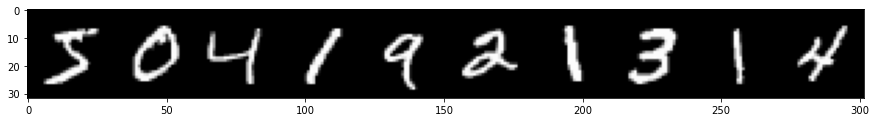

In [5]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))

demo_pred = model(images.to(device))
demo_pred_label = [l[0] for l in list(torch.topk(demo_pred, 1)[1].cpu().detach().numpy())]

print("Predictions: ", end=" ")
for l in enumerate(demo_pred_label):
    print(l[1], end=", ")

Predictions:  7, 2, 2, 7, 9, 7, 7, 7, 7, 7, 

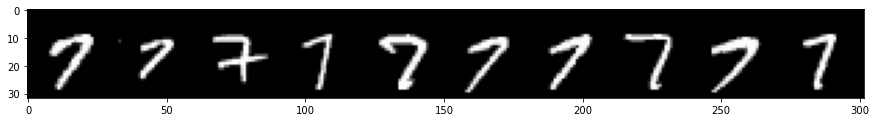

In [6]:
demo_start = 700
demo_images = manifold_sampler.pivots[demo_start:demo_start + 10]

grid = torchvision.utils.make_grid(demo_images, nrow=10)
plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))

demo_pred = model(demo_images.to(device))
demo_pred_label = [l[0] for l in list(torch.topk(demo_pred, 1)[1].cpu().detach().numpy())]

print("Predictions: ", end=" ")
for l in enumerate(demo_pred_label):
    print(l[1], end=", ")

In [7]:
from sklearn import linear_model

sigma = 10
sim_sigma = 4

def similarity_kernel(v1,v2,kernel_width = 1):
    l2_dist = np.linalg.norm(v1 - v2)
    return np.exp(- (l2_dist**2) / (kernel_width**2))

def normalize(v, r):
    return v/np.sqrt(np.sum(v**2))*r

def view_10(model_, inputs_, offset_ = 0, view_pred = False):
    demo_start = offset_
    demo_images = inputs_[demo_start:demo_start + 10]
    img_min = torch.min(demo_images)
    demo_images = demo_images - torch.min(demo_images)
    demo_images = demo_images/torch.max(demo_images)

    grid = torchvision.utils.make_grid(demo_images, nrow=10)
    plt.figure(figsize=(15, 20))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    
    if view_pred == True:
        demo_pred = model_(demo_images.float().to(device))
        demo_pred_label = [l[0] for l in list(torch.topk(demo_pred, 1)[1].cpu().detach().numpy())]

        print("Predictions: ", end=" ")
        for l in enumerate(demo_pred_label):
            print(l[1], end=", ")

In [8]:
DUPLICATIONS = 10
RADIUS = 100.0
base_RADIUS = 0.0
base_images = []
perturbations = []
gauss_perturb = []
for _ in range(DUPLICATIONS):
    # base
    base_gauss_ = np.random.normal(0, 1, size=manifold_sampler.pivots.shape)
    r = np.random.uniform()*base_RADIUS
    base_gauss_norm = normalize(base_gauss_, r)
    base_pc = manifold_sampler.to_1d(manifold_sampler.pivots + base_gauss_norm)
    
    # gauss
    gauss_ = np.random.normal(0, 1, size=manifold_sampler.pivots.shape)
    gauss_noise = manifold_sampler.to_1d(gauss_)
    plane_noise = np.zeros_like(gauss_noise)
    for d in range(Gv.shape[0]):
        proj = np.dot(gauss_noise, Gv[d])
        for s in range(plane_noise.shape[0]):
            plane_noise[s] = plane_noise[s] + proj[s]*Gv[d]        
    ortho_noise = gauss_noise - plane_noise
    
    # noise
    r = np.random.uniform()*RADIUS
    ortho_norm = normalize(ortho_noise, r)
    gauss_norm = normalize(gauss_noise, r)
    ortho_pc = base_pc + ortho_norm
    gauss_pc = base_pc + gauss_norm
    base_images.append(manifold_sampler.to_3d(base_pc))
    perturbations.append(manifold_sampler.to_3d(ortho_pc))
    gauss_perturb.append(manifold_sampler.to_3d(gauss_pc))
    
base_images   = torch.cat(base_images)
perturbations = torch.cat(perturbations)
gauss_perturb = torch.cat(gauss_perturb)
base_embeded    = manifold_sampler.transform(base_images)
perturb_embeded = manifold_sampler.transform(perturbations)
gauss_embeded   = manifold_sampler.transform(gauss_perturb)

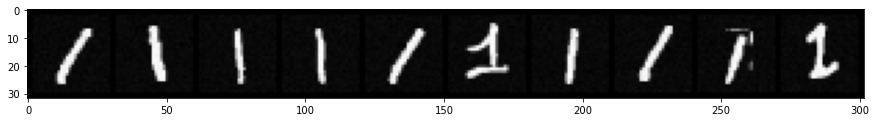

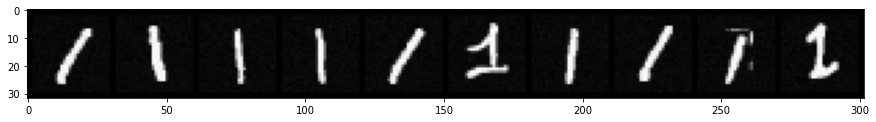

In [9]:
offset = 2100
view_10(model, perturbations, offset)
view_10(model, gauss_perturb, offset)

(-0.5, 27.5, 27.5, -0.5)

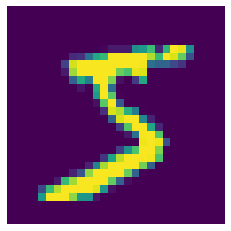

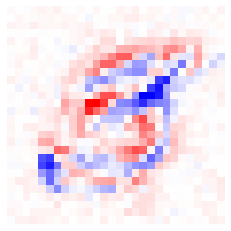

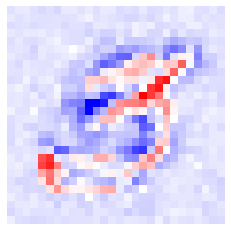

In [78]:
index_to_explain = 500
image_to_explain = manifold_sampler.pivots[index_to_explain]

perturb_outputs = model(perturbations.float().to(device))
probs = nn.functional.softmax(perturb_outputs, dim = 1)

original_output = model(image_to_explain.unsqueeze(0).to(device))
first_prediction, second_prediction = torch.topk(original_output, 2)[1][0]
perturb_1st = probs[:,first_prediction.item()].cpu().detach().numpy()
perturb_2nd = probs[:,second_prediction.item()].cpu().detach().numpy()

base_embeded = manifold_sampler.transform(image_to_explain.unsqueeze(0))
similarities = [similarity_kernel(perturb_embeded[i], base_embeded, kernel_width = 1) for i in range(perturbations.shape[0])]

repeat_shape = (perturbations.shape[0],) + tuple(np.ones(image_to_explain.ndim). astype(int))
repeat_image_to_explain = image_to_explain.repeat(repeat_shape)
true_perturb = perturbations - repeat_image_to_explain

clf = linear_model.Ridge(alpha = 200)
clf.fit((true_perturb).reshape(true_perturb.shape[0], channels*rows*cols), perturb_1st, sample_weight=similarities)
explanation_1st = clf.coef_.reshape(rows, cols)
clf.fit((true_perturb).reshape(true_perturb.shape[0], channels*rows*cols), perturb_2nd, sample_weight=similarities)
explanation_2nd = clf.coef_.reshape(rows, cols)

plt.figure()
plt.imshow(image_to_explain[0])
plt.axis('off')
plt.figure()
plt.imshow(explanation_1st, cmap=plt.get_cmap('bwr'))
plt.axis('off')
plt.figure()
plt.imshow(explanation_2nd, cmap=plt.get_cmap('bwr'))
plt.axis('off')


In [31]:
index_to_explain = 500
image_to_explain = manifold_sampler.pivots[index_to_explain]

perturb_outputs = model(perturbations.float().to(device))
probs = nn.functional.softmax(perturb_outputs, dim = 1)

base_embeded = manifold_sampler.transform(image_to_explain.unsqueeze(0))
similarities = [similarity_kernel(perturb_embeded[i], base_embeded, kernel_width = 1) for i in range(perturbations.shape[0])]

repeat_shape = (perturbations.shape[0],) + tuple(np.ones(image_to_explain.ndim). astype(int))
repeat_image_to_explain = image_to_explain.repeat(repeat_shape)
true_perturb = perturbations - repeat_image_to_explain

clf = linear_model.Ridge(alpha = 200)
image_to_explain_np = image_to_explain[0].cpu().detach().numpy()
forplots = []
for out in range(probs.shape[1]):
    perturb_pred = probs[:,out].cpu().detach().numpy()
    clf.fit(np.abs(true_perturb).reshape(true_perturb.shape[0], channels*rows*cols), perturb_pred, sample_weight=similarities)
    explanation = clf.coef_.reshape(rows, cols)
    forplots.append(explanation)

In [90]:
def plot_forplots(base_img, list_of_imgs, label = 0):
    max_val = np.max(np.asarray([np.max(x) for x in list_of_imgs]))
    min_val = np.min(np.asarray([np.min(x) for x in list_of_imgs]))
    mag_val = max([abs(max_val),abs(min_val)])
    size = 2
    cols = len(list_of_imgs)
    figure, axes = plt.subplots(nrows=1, ncols=1+cols, figsize=(size*(cols),size))
    axes.ravel()[0].imshow(base_img, cmap=plt.get_cmap('Greys'))
    axes.ravel()[0].set_axis_off()
    for a in range(cols):
        img = list_of_imgs[a]
        axes.ravel()[a+1].imshow(img, cmap=plt.get_cmap('coolwarm'),
                                vmin=-mag_val, vmax=mag_val)
        axes.ravel()[a+1].set_axis_off()
    plt.tight_layout()
    plt.savefig("mnist_viz/mnist_" + str(label) + ".jpg")

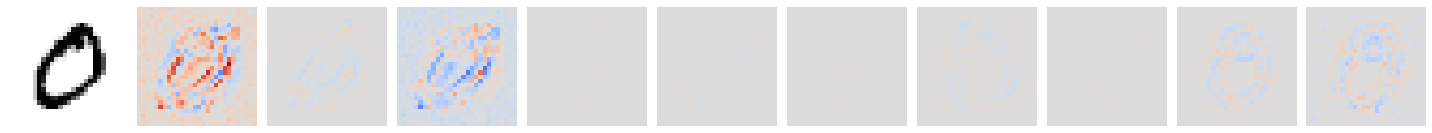

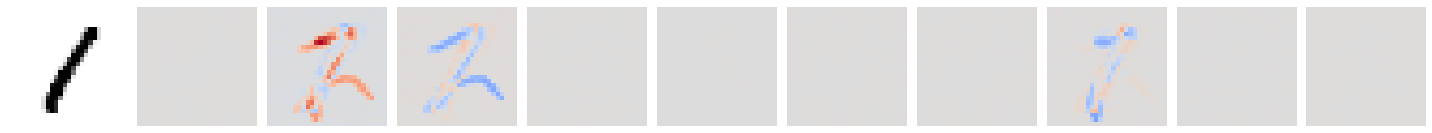

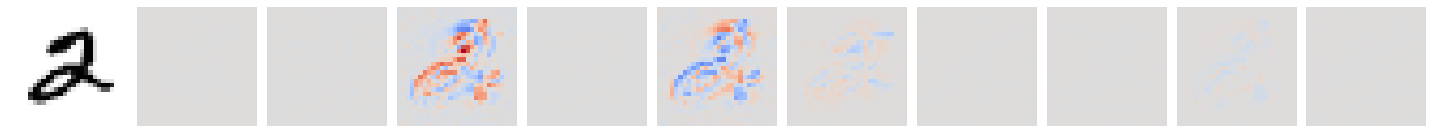

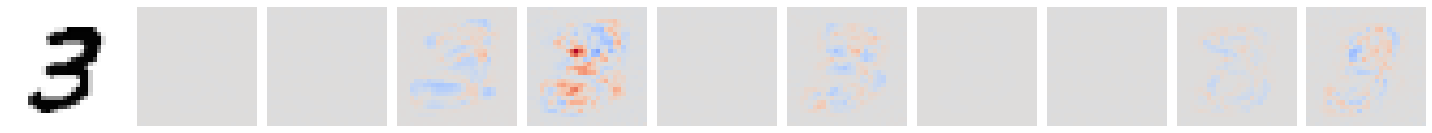

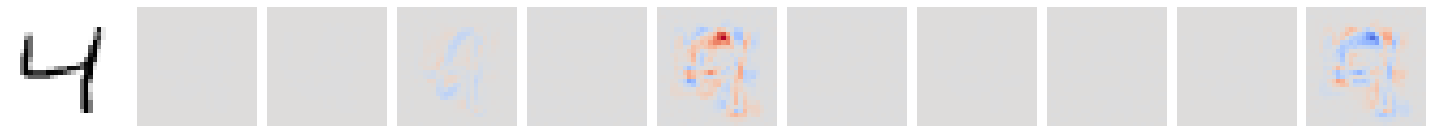

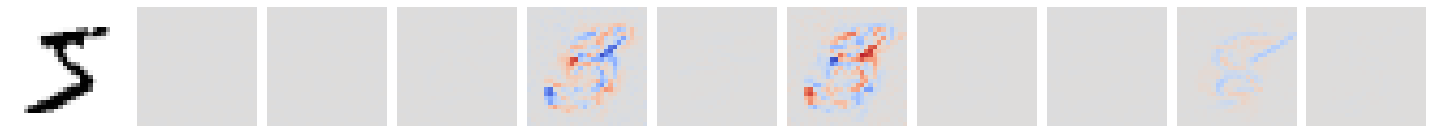

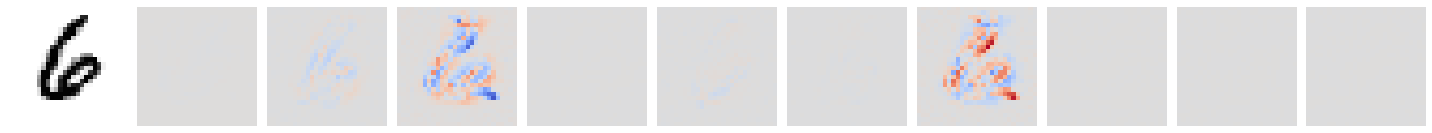

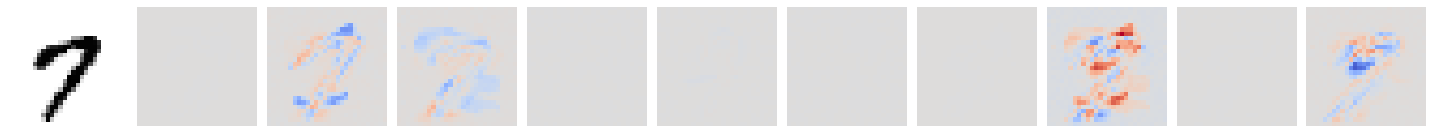

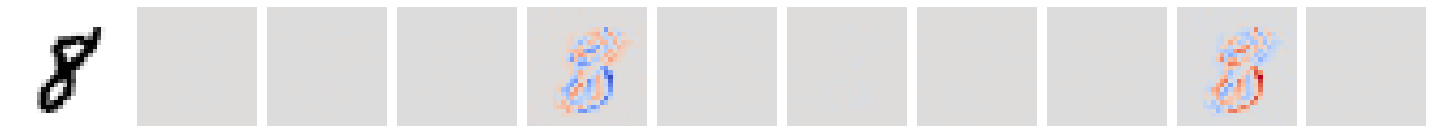

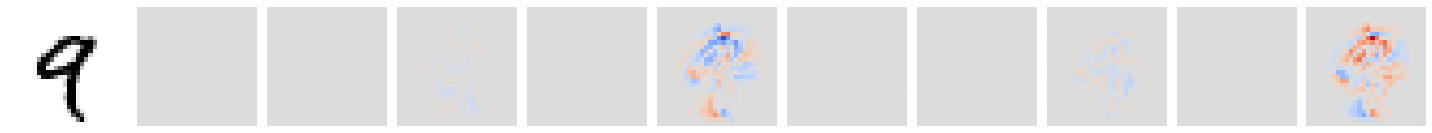

In [91]:
for index_to_explain in [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]:
    image_to_explain = manifold_sampler.pivots[index_to_explain]

    perturb_outputs = model(perturbations.float().to(device))
    probs = nn.functional.softmax(perturb_outputs, dim = 1)

    base_embeded = manifold_sampler.transform(image_to_explain.unsqueeze(0))
    similarities = [similarity_kernel(perturb_embeded[i], base_embeded, kernel_width = 1) for i in range(perturbations.shape[0])]

    repeat_shape = (perturbations.shape[0],) + tuple(np.ones(image_to_explain.ndim). astype(int))
    repeat_image_to_explain = image_to_explain.repeat(repeat_shape)
    true_perturb = perturbations - repeat_image_to_explain

    clf = linear_model.Ridge(alpha = 200)
    image_to_explain_np = image_to_explain[0].cpu().detach().numpy()
    forplots = []
    for out in range(probs.shape[1]):
        perturb_pred = probs[:,out].cpu().detach().numpy()
        clf.fit(np.abs(true_perturb).reshape(true_perturb.shape[0], channels*rows*cols), perturb_pred, sample_weight=similarities)
        explanation = clf.coef_.reshape(rows, cols)
        forplots.append(-explanation)

    plot_forplots(image_to_explain_np, forplots, index_to_explain)

(-0.5, 27.5, 27.5, -0.5)

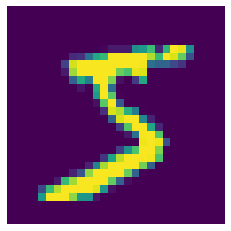

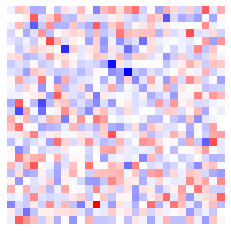

In [74]:
base_similarities = similarities = [similarity_kernel(gauss_perturb[i], image_to_explain.unsqueeze(0), kernel_width = 1) for i in range(perturbations.shape[0])]
true_gauss_diff = gauss_perturb - repeat_image_to_explain 

clf = linear_model.Ridge(alpha = 100)
clf.fit(np.abs(true_gauss_diff).reshape(true_gauss_diff.shape[0], channels*rows*cols), perturb_1st, sample_weight=base_similarities)
explanation_gauss = -clf.coef_.reshape(rows, cols)
# clf.fit(np.abs(true_perturb).reshape(true_perturb.shape[0], channels*rows*cols), perturb_2nd, sample_weight=similarities)
# explanation_2nd = -clf.coef_.reshape(rows, cols)

plt.figure()
plt.imshow(image_to_explain[0])
plt.axis('off')
plt.figure()
plt.imshow(explanation_gauss, cmap=plt.get_cmap('bwr'))
plt.axis('off')

In [75]:
view_label = 1

shap_bg = torch.mean(base_images[view_label*1000:(view_label+1)*1000], dim = 0)

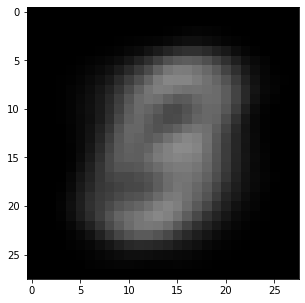

In [76]:
grid = torchvision.utils.make_grid(shap_bg, nrow=10)
plt.figure(figsize=(5, 5))
plt.imshow(np.transpose(grid, (1, 2, 0)))

In [77]:
from skimage.segmentation import slic, quickshift
from skimage.segmentation import mark_boundaries

def torch_img_to_np(torch_img):
    np_img = torch_img.numpy()
    np_img = np.swapaxes(np_img,0,1)
    np_img = np.swapaxes(np_img,1,2)
    np_img = np.swapaxes(np_img,2,3)
    return np_img[0]

def np_to_torch_img(np_img):
    np_img = np.swapaxes(np_img,2,1)
    np_img = np.swapaxes(np_img,1,0)
    torch_img = torch.Tensor(np_img)
    return torch_img.unsqueeze(0)

def segment_img(torch_img, n_segments=10, compactness=2, sigma=1, start_label=0):
    np_img = torch_img_to_np(torch_img)
    segments_slic = slic(np_img, n_segments=n_segments, compactness=compactness,
                         sigma=sigma, start_label=start_label)
    return np_img, np.repeat(np_img, 3, axis=2), segments_slic

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


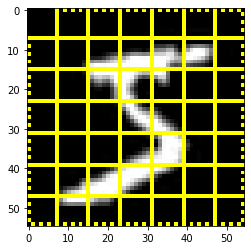

In [78]:
np_bg = torch_img_to_np(shap_bg.unsqueeze(0))
np_im, np_3D_im, segments_slic = segment_img(image_to_explain.unsqueeze(0), n_segments=50, compactness=100, sigma=1, start_label=0)

plt.imshow(mark_boundaries(np_3D_im, segments_slic, mode = 'subpixel'))

In [79]:
def shap_score(model, torch_img, torch_bg, runs = 1):
    np_bg = torch_img_to_np(torch_bg.unsqueeze(0))
    np_im, np_3D_im, segments_slic = segment_img(torch_img.unsqueeze(0), n_segments=64, compactness=0.0001, sigma=0.1, start_label=0)
    
    original_output = model(torch_img.unsqueeze(0).to(device))
    ori_probs = nn.functional.softmax(original_output, dim = 1)
    first_prediction, second_prediction = torch.topk(original_output, 2)[1][0]
    ori_probs_value = ori_probs[:,first_prediction.item()].cpu().detach().numpy()
    
    perturbation_output = model(torch_bg.unsqueeze(0).float().to(device))
    perturb_probs = nn.functional.softmax(perturbation_output, dim = 1)
    perturb_init_value = perturb_probs[:,first_prediction.item()].cpu().detach().numpy()

    score = np.zeros_like(segments_slic).astype(np.float32)
    segment_idx = list(np.unique(segments_slic))
    old_value = perturb_init_value
    
    np_shap_perturb = np_bg.copy()
    for r in range(runs):
        random.shuffle(segment_idx)
        np_shap_perturb = np_bg.copy()
        for feature_value in segment_idx:
            np_shap_perturb[segments_slic == feature_value] = np_im[segments_slic == feature_value]
            torch_shap_perturb = np_to_torch_img(np_shap_perturb)
            torch_shap_pred = model(torch_shap_perturb.to(device))
            shap_probs = nn.functional.softmax(torch_shap_pred, dim = 1)
            torch_shap_pred_value = shap_probs[:,first_prediction.item()].cpu().detach().numpy()
            inc_score = torch_shap_pred_value - old_value
            old_value = torch_shap_pred_value
            score[segments_slic == feature_value] =+ inc_score[0]
    return score/runs

(-0.5, 27.5, 27.5, -0.5)

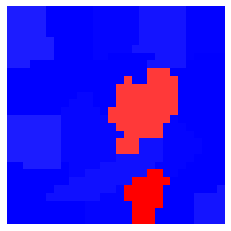

In [80]:
score = shap_score(model, image_to_explain, shap_bg, runs = 200)
plt.imshow(np.abs(score),cmap=plt.get_cmap('bwr'))
plt.axis('off')